In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from glob import glob
from astropy.table import Table
from astropy.visualization import make_lupton_rgb

In [3]:
images_ngc6946=sorted(glob('project1_example/img20181007004*.fits'))
images_ngc188=sorted(glob('project1_example/img2018101*.fits'))
calibrations=sorted(glob('calibs/**'))

In [4]:
def imsorter(images): #returns array of arrays, index 0-3 goes g,u,i,r filter.
    x=0
    returnarray=[]
    g=[]
    u=[]
    i=[]
    r=[]
    while x<len(images):
        hdul = fits.open(images[x])  # open a FITS file
        hdr = hdul[0].header
        if hdr['INSFILTE']=='g':
            g.append(images[x])
        if hdr['INSFILTE']=='u':
            u.append(images[x])
        if hdr['INSFILTE']=='i':
            i.append(images[x])
        if hdr['INSFILTE']=='r':
            r.append(images[x])
        x+=1
    returnarray.append(g)
    returnarray.append(u)
    returnarray.append(i)
    returnarray.append(r)
    
    return returnarray

In [5]:
#sorting images
ngc6946=imsorter(images_ngc6946)
ngc188=imsorter(images_ngc188)

In [6]:
#sorting calibration files (flats and biases) 
y=0
gflat=[]
uflat=[]
iflat=[]
rflat=[]
bias=[]
while y<len(calibrations):
    cals=fits.open(calibrations[y])
    calshead=cals[0].header
    if calshead['OBJECT']=='u_flat':
        uflat.append(calibrations[y])
    if calshead['OBJECT']=='g_flat':
        gflat.append(calibrations[y])
    if calshead['OBJECT']=='i_flat':
        iflat.append(calibrations[y])
    if calshead['OBJECT']=='r_flat':
        rflat.append(calibrations[y])
    if calshead['OBJECT']=='ICEX_zero':
        bias.append(calibrations[y])
    y+=1
    
#this gives exposure time cals[0].header['EXPTIME']
#divide by median of master after making it so that median is 1
#fits.open(images_ngc6946[0])[0].header['EXPTIME']

In [169]:
def combinerbias(flat):
    x=[]
    for y in flat:
        x.append(fits.getdata(y))#pulls a bias, converts to an array, then adds it to the array of arrays
    return x

In [170]:
#creating bias
master_bias=np.median(combinerbias(bias),axis=0)

In [196]:
def combiner(flat):
    x=[]
    for y in flat:
        x.append((fits.getdata(y)/fits.open(y)[0].header['EXPTIME']-master_bias))#pulls a flat, converts to an array, divides by exposure time, subtracts the master bias, then adds it to the array of arrays
    return x

In [197]:
#creating master flats and divide by median to send median to 1
master_gflat=np.median(combiner(gflat),axis=0)
master_uflat=np.median(combiner(uflat),axis=0)
master_iflat=np.median(combiner(iflat),axis=0)
master_rflat=np.median(combiner(rflat),axis=0)


In [198]:
#apply calibrations to images
#ngc6946 has g,u,i
#ngc188 has g,r

#ngc6946 dividing by flats
g6946=fits.getdata(ngc6946[0][0])
u6946=fits.getdata(ngc6946[1][0])
i6946=fits.getdata(ngc6946[2][0])


g6946_processed=g6946/master_gflat
u6946_processed=u6946/master_uflat
i6946_processed=i6946/master_iflat

#same stuff but for ngc188
g188=fits.getdata(ngc188[0][0])
r188=fits.getdata(ngc188[3][0])

g188_processed=g188/master_gflat
r188_processed=r188/master_rflat

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


In [199]:
print(u6946_processed)

[[-1.06911719 -1.02829299 -1.02104932 ... -1.00351482 -1.00498555
  -1.00491352]
 [-1.06637612 -1.02914447 -1.04172983 ... -1.00518579 -1.00446824
  -1.00387237]
 [-1.07681668 -1.04697723 -1.04462109 ... -1.00482672 -1.00287907
  -1.00410592]
 ...
 [-1.10947533 -1.04329431 -1.042085   ... -1.00376412 -1.0050275
  -1.00565662]
 [-1.10126107 -1.04108029 -1.03903983 ... -1.00345547 -1.00250784
  -1.00470849]
 [-1.09105164 -1.04223702 -1.03762634 ... -1.00345093 -1.0031348
  -1.00408252]]


In [200]:
def infinity_remover(arry): #takes out infinities, replaces them with 0
    for (x,y), value in np.ndenumerate(arry):
        if arry[x,y]==np.inf or arry[x,y]==-np.inf:
            arry[x,y]=0
    return arry

In [201]:
#probably wont use this but I wrote it so lets keep it around in case it becomes useful
#
def outlier_remover(arry, sig):
    mean=np.mean(arry)
    sd=np.std(arry)
    returnarry=np.zeros(arry.shape)
    i=0
    for (x,y), value in np.ndenumerate(arry):
        if (mean-sig*sd)<=arry[x,y]<=(mean+sig*sd):
            returnarry[x,y]=arry[x,y]
            i+=1
    print(i, mean, sd)
    return returnarry

In [202]:
g6946_processed2=infinity_remover(g6946_processed)
u6946_processed2=infinity_remover(u6946_processed)
i6946_processed2=infinity_remover(i6946_processed)

g188_processed2=infinity_remover(g188_processed)
r188_processed2=infinity_remover(r188_processed)

In [210]:
#median is mostly coming from sky. multiple by negative to flip the fluxes to positive
g6946_final=-(g6946_processed2-np.median(g6946_processed2))
u6946_final=-(u6946_processed2-np.median(u6946_processed2))
i6946_final=-(i6946_processed2-np.median(i6946_processed2))

g188_final=-(g188_processed2-np.median(g188_processed2))
r188_final=-(r188_processed2-np.median(r188_processed2))

In [211]:
img6946=fits.PrimaryHDU(g6946_final)
img6946.writeto('g6946.fits',clobber=True)
imu6946=fits.PrimaryHDU(u6946_final)
imu6946.writeto('u6946.fits',clobber=True)
imi6946=fits.PrimaryHDU(i6946_final)
imi6946.writeto('i6946.fits',clobber=True)

In [212]:
#creating subimage around star cluster
#y 250-1000
#x 750-1500
r188sub=np.zeros((750,850))
g188sub=np.zeros((750,850))
r188sub.shape
for x in range(650,1500):
    for y in range(250,1000):
        #print(y,x)
        r188sub[y-250][x-650]=r188_final[y][x]
        g188sub[y-250][x-650]=g188_final[y][x]



In [213]:
imr188=fits.PrimaryHDU(r188sub)
imr188.writeto('r188.fits',clobber=True)
img188=fits.PrimaryHDU(g188sub)
img188.writeto('g188.fits',clobber=True)

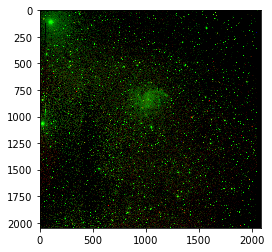

In [215]:
#create rgb image of galaxy from different bands
image_ngc6946 = make_lupton_rgb(1.5*i6946_final, 4*g6946_final, u6946_final, Q=10, stretch=0.5)
plt.imshow(image_ngc6946)
#minimum=[np.percentile(i6946_final,1),np.percentile(g6946_final,1,),np.percentile(u6946_final,1)]

In [22]:
#START STAR CLUSTER STUFF BELOW

In [245]:
#Reprojecting g onto r. 
from astropy.utils.data import get_pkg_data_filename
from reproject import reproject_interp

hdu1g = fits.open(get_pkg_data_filename('project1_example/new-image-g188.fits'))[0]
hdu2r = fits.open(get_pkg_data_filename('project1_example/new-image-r188.fits'))[0]

array, footprint = reproject_interp(hdu1g, hdu2r.header)
fits.writeto('g_on_r.fits', array, hdu2r.header, clobber=True)

In [246]:
from astropy.io import ascii
catr=ascii.read('project1_example/testr1.cat')#this is the r filter
catg=ascii.read('project1_example/testg1.cat')#this is the g filter

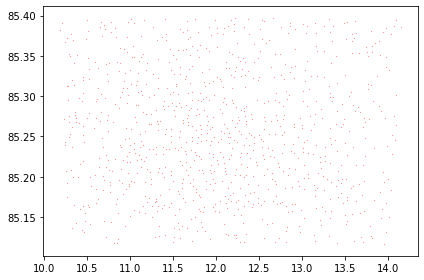

In [247]:
ra=np.array(catr['ALPHA_J2000'])
dec=np.array(catr['DELTA_J2000'])
plt.figure()
plt.scatter(ra,dec,c='red',marker='.',s=0.1)
plt.tight_layout()

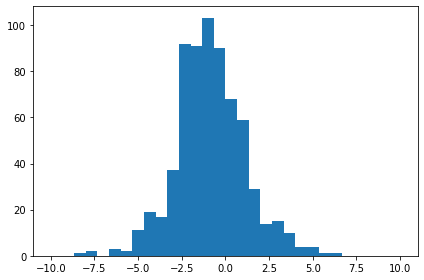

In [248]:
fluxr=np.array(catr['FLUX_AUTO'])
fluxg=np.array(catg['FLUX_AUTO'])
g=np.where(fluxr < 0.0) ; fluxr[g]=1e-30
magr=(-2.5)*np.log10(fluxr)
magg=(-2.5)*np.log10(fluxg)
plt.figure()
plt.hist(magr,bins=30,range=[-10,10])
plt.tight_layout(); plt.show(); plt.close()

In [249]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.vizier import Vizier
from astropy.utils.console import ProgressBar

In [250]:
v = Vizier(columns=['RAJ2000', 'DEJ2000','umag', 'gmag', 'rmag','imag'])

In [251]:
#Building catalog for r band


ps_rmag=np.zeros(len(ra))
#print(len(ps_rmag))# An empty array to fill with the PS (Pan-STAARS) r-band magnitude for my 200 objects
nr=len(ra) #for full catalog

for i in range(1,nr):
    posr = SkyCoord(ra[i]*u.deg, dec[i]*u.deg, frame='icrs') #Make a SkyCoord object for index i of my list of 200 stars
    #print(posr)
    resultr=v.query_region(posr,width="60s",catalog='panstarrs')[0] #Query Vizier for sources within 60 arcsec of this position
    
   # if resultr: #if this catalog is not empty:
       # print("catalog is not empty. here it is:", resultr)
    
    if not resultr:
        print("catalog is empty. move on")
        continue
        
    #print(len(resultr))
    
    #At this point, I have a lot of sources, since many will be within 60"
    #I only want the closest one, so I need to measure the angular distance
    
    distr=np.zeros(len(resultr['rmag'])) #Set up an empty distance array
    trar=np.array(resultr['RAJ2000']) #Make a variable for the PS RA
    tdecr=np.array(resultr['DEJ2000']) #Make a variable for the PS Dec
    for j in range(len(distr)): #Run a loop over the PS objects to measure the distance
        tobjr=SkyCoord(trar[j]*u.deg,tdecr[j]*u.deg,frame='icrs')
        distr[j]=tobjr.separation(posr).arcsec
    #Now I have the measured distances. I want the closest one, but only if its close enough I'm sure its the same object
    #I'll be a little liberal, and assume I've found the closest one if its at < 10"
    r=np.where((distr <= 10.0) & (distr==np.min(distr)))[0]
    print("r is",r)
    #print("rmag at r is",resultr['rmag'][r][0])
    rcat = np.asarray(resultr['rmag'][r])
    print(rcat)
    if not rcat:
    #If there is no match, set the mag to some crazy value nowhere near a real value
        ps_rmag[i]=float(-99)
        print("rcat is empty.", rcat)

    else:
        #if len(r[0]) > 0: #If there is a match within 10", then put the PS r-band magnitude in my array
        print("rcat is true. length is", len(rcat))
        #ps_rmag[i]=float(resultr[0]['rmag'][r][0])
        ps_rmag[i] = float(rcat[0])
#

r is [2]
[nan]
rcat is true. length is 1
r is [7]
[15.7882]
rcat is true. length is 1
r is [7]
[12.953]
rcat is true. length is 1
r is [0]
[14.3531]
rcat is true. length is 1
r is [8]
[14.8641]
rcat is true. length is 1
r is [2]
[14.6477]
rcat is true. length is 1
r is [9]
[14.733]
rcat is true. length is 1
r is [5]
[16.38]
rcat is true. length is 1
r is [1]
[16.1425]
rcat is true. length is 1
r is [3]
[16.5353]
rcat is true. length is 1
r is [11]
[14.8356]
rcat is true. length is 1
r is [8]
[10.8437]
rcat is true. length is 1
r is [4]
[12.925]
rcat is true. length is 1
r is [2]
[17.5535]
rcat is true. length is 1
r is [4]
[15.4169]
rcat is true. length is 1
r is [6]
[16.7029]
rcat is true. length is 1
r is [5]
[18.4379]
rcat is true. length is 1
r is [1]
[13.293]
rcat is true. length is 1
r is [1]
[15.1616]
rcat is true. length is 1
r is [7]
[16.2489]
rcat is true. length is 1
r is [10]
[16.4823]
rcat is true. length is 1
r is [1]
[15.0683]
rcat is true. length is 1
r is [3]
[16.755]


/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


r is [8]
[14.8535]
rcat is true. length is 1
r is [0]
[16.1648]
rcat is true. length is 1
r is [5]
[15.9121]
rcat is true. length is 1
r is [3]
[18.4457]
rcat is true. length is 1
r is [5]
[19.1503]
rcat is true. length is 1
r is [13]
[18.6304]
rcat is true. length is 1
r is [4]
[19.043]
rcat is true. length is 1
r is [5]
[15.6145]
rcat is true. length is 1
r is [3]
[16.0036]
rcat is true. length is 1
r is [3]
[17.1461]
rcat is true. length is 1
r is [5]
[17.1621]
rcat is true. length is 1
r is [4]
[14.8696]
rcat is true. length is 1
r is [2]
[14.2356]
rcat is true. length is 1
r is [1]
[nan]
rcat is true. length is 1
r is [7]
[16.1112]
rcat is true. length is 1
r is [2]
[15.8629]
rcat is true. length is 1
r is [3]
[15.9531]
rcat is true. length is 1
r is []
[]
rcat is empty. []


/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


r is [1]
[16.1658]
rcat is true. length is 1
r is [7]
[18.4147]
rcat is true. length is 1
r is [5]
[17.2188]
rcat is true. length is 1
r is [7]
[15.1899]
rcat is true. length is 1
r is [1]
[15.2645]
rcat is true. length is 1
r is [13]
[18.0839]
rcat is true. length is 1
r is [2]
[15.834]
rcat is true. length is 1
r is [3]
[18.2745]
rcat is true. length is 1
r is [7]
[18.3357]
rcat is true. length is 1
r is [1]
[14.8265]
rcat is true. length is 1
r is [2]
[16.4827]
rcat is true. length is 1
r is [0]
[18.9868]
rcat is true. length is 1
r is [2]
[15.385]
rcat is true. length is 1
r is [4]
[nan]
rcat is true. length is 1
r is [6]
[18.7577]
rcat is true. length is 1
r is [0]
[17.422]
rcat is true. length is 1
r is [1]
[13.147]
rcat is true. length is 1
r is [2]
[17.543]
rcat is true. length is 1
r is [2]
[18.2514]
rcat is true. length is 1
r is [1]
[18.2608]
rcat is true. length is 1
r is [4]
[17.8255]
rcat is true. length is 1
r is [3]
[20.5434]
rcat is true. length is 1
r is [0]
[18.1245]

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


r is [5]
[16.8028]
rcat is true. length is 1
r is [0]
[17.2008]
rcat is true. length is 1
r is [2]
[16.5342]
rcat is true. length is 1
r is [4]
[18.7219]
rcat is true. length is 1
r is [3]
[16.9957]
rcat is true. length is 1
r is [3]
[16.3903]
rcat is true. length is 1
r is [7]
[18.455]
rcat is true. length is 1
r is [12]
[18.7848]
rcat is true. length is 1
r is [11]
[19.1682]
rcat is true. length is 1
r is [4]
[18.5605]
rcat is true. length is 1
r is [2]
[15.1632]
rcat is true. length is 1
r is [4]
[18.8218]
rcat is true. length is 1
r is [7]
[nan]
rcat is true. length is 1
r is []
[]
rcat is empty. []


/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


r is [0]
[19.9015]
rcat is true. length is 1
r is [2]
[16.4558]
rcat is true. length is 1
r is [1]
[15.534]
rcat is true. length is 1
r is [6]
[16.1547]
rcat is true. length is 1
r is [1]
[14.7994]
rcat is true. length is 1
r is [3]
[17.4757]
rcat is true. length is 1
r is [10]
[16.3911]
rcat is true. length is 1
r is [0]
[20.2296]
rcat is true. length is 1
r is [3]
[14.5924]
rcat is true. length is 1
r is [1]
[16.8142]
rcat is true. length is 1
r is [2]
[16.101]
rcat is true. length is 1
r is [1]
[nan]
rcat is true. length is 1
r is [2]
[18.9368]
rcat is true. length is 1
r is [1]
[17.2208]
rcat is true. length is 1
r is [6]
[15.4725]
rcat is true. length is 1
r is [1]
[14.6496]
rcat is true. length is 1
r is [0]
[20.3267]
rcat is true. length is 1
r is [3]
[16.1381]
rcat is true. length is 1
r is [0]
[16.7283]
rcat is true. length is 1
r is [3]
[14.4857]
rcat is true. length is 1
r is [2]
[15.2968]
rcat is true. length is 1
r is [5]
[18.3224]
rcat is true. length is 1
r is [3]
[15.28

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


r is [6]
[17.5386]
rcat is true. length is 1
r is [8]
[14.156]
rcat is true. length is 1
r is [3]
[16.5863]
rcat is true. length is 1
r is [9]
[15.229]
rcat is true. length is 1
r is [6]
[16.6037]
rcat is true. length is 1
r is [4]
[18.3083]
rcat is true. length is 1
r is [6]
[15.8847]
rcat is true. length is 1
r is [0]
[16.1558]
rcat is true. length is 1
r is [6]
[14.8411]
rcat is true. length is 1
r is [4]
[15.6271]
rcat is true. length is 1
r is [10]
[15.7916]
rcat is true. length is 1
r is [7]
[15.7155]
rcat is true. length is 1
r is [1]
[13.17]
rcat is true. length is 1
r is [3]
[17.6763]
rcat is true. length is 1
r is []
[]
rcat is empty. []


/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


r is [4]
[18.5706]
rcat is true. length is 1
r is [2]
[17.5203]
rcat is true. length is 1
r is [4]
[17.4388]
rcat is true. length is 1
r is [4]
[16.9356]
rcat is true. length is 1
r is [0]
[15.9201]
rcat is true. length is 1
r is [4]
[17.7797]
rcat is true. length is 1
r is [7]
[14.8344]
rcat is true. length is 1
r is [3]
[15.7136]
rcat is true. length is 1
r is [5]
[15.6651]
rcat is true. length is 1
r is [0]
[11.564]
rcat is true. length is 1
r is [10]
[16.4607]
rcat is true. length is 1
r is [6]
[18.4612]
rcat is true. length is 1
r is [11]
[17.3903]
rcat is true. length is 1
r is [7]
[17.1505]
rcat is true. length is 1
r is [5]
[14.6481]
rcat is true. length is 1
r is [9]
[16.8084]
rcat is true. length is 1
r is [12]
[17.6222]
rcat is true. length is 1
r is [3]
[15.9209]
rcat is true. length is 1
r is [6]
[16.288]
rcat is true. length is 1
r is [3]
[15.5709]
rcat is true. length is 1
r is [5]
[15.3576]
rcat is true. length is 1
r is [3]
[16.7221]
rcat is true. length is 1
r is [1]


/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


r is [7]
[19.1159]
rcat is true. length is 1
r is [4]
[17.0961]
rcat is true. length is 1
r is [6]
[18.433]
rcat is true. length is 1
r is [9]
[15.1753]
rcat is true. length is 1
r is [10]
[14.7832]
rcat is true. length is 1
r is [4]
[16.7048]
rcat is true. length is 1
r is [5]
[20.5063]
rcat is true. length is 1
r is [7]
[15.934]
rcat is true. length is 1
r is [6]
[14.903]
rcat is true. length is 1
r is [2]
[15.3508]
rcat is true. length is 1
r is [8]
[15.8878]
rcat is true. length is 1
r is [6]
[18.6445]
rcat is true. length is 1
r is [1]
[18.1711]
rcat is true. length is 1
r is [3]
[18.8721]
rcat is true. length is 1
r is [3]
[21.1671]
rcat is true. length is 1
r is [5]
[15.8533]
rcat is true. length is 1
r is [11]
[15.7623]
rcat is true. length is 1
r is [11]
[12.3153]
rcat is true. length is 1
r is [3]
[14.8923]
rcat is true. length is 1
r is [9]
[15.1711]
rcat is true. length is 1
r is [3]
[13.7163]
rcat is true. length is 1
r is [11]
[15.8778]
rcat is true. length is 1
r is [6]


/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


r is [5]
[16.0695]
rcat is true. length is 1
r is [8]
[20.2541]
rcat is true. length is 1
r is [5]
[16.916]
rcat is true. length is 1
r is [0]
[18.2652]
rcat is true. length is 1
r is [7]
[17.7517]
rcat is true. length is 1
r is [3]
[16.4182]
rcat is true. length is 1
r is [7]
[15.3989]
rcat is true. length is 1
r is [1]
[15.8096]
rcat is true. length is 1
r is [4]
[16.1802]
rcat is true. length is 1
r is [0]
[16.0766]
rcat is true. length is 1
r is [5]
[14.7653]
rcat is true. length is 1
r is [6]
[18.7522]
rcat is true. length is 1
r is [7]
[15.0516]
rcat is true. length is 1
r is [4]
[18.3789]
rcat is true. length is 1
r is [1]
[17.8216]
rcat is true. length is 1
r is [1]
[16.4091]
rcat is true. length is 1
r is [0]
[15.1072]
rcat is true. length is 1
r is [1]
[15.4164]
rcat is true. length is 1
r is [13]
[16.7683]
rcat is true. length is 1
r is [4]
[14.3161]
rcat is true. length is 1
r is [9]
[15.0445]
rcat is true. length is 1
r is [5]
[18.9312]
rcat is true. length is 1
r is [2]
[

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


r is [9]
[16.4924]
rcat is true. length is 1
r is [3]
[18.2698]
rcat is true. length is 1
r is [3]
[14.8934]
rcat is true. length is 1
r is [7]
[14.7004]
rcat is true. length is 1
r is [8]
[12.126]
rcat is true. length is 1
r is [7]
[14.8095]
rcat is true. length is 1
r is [0]
[15.2749]
rcat is true. length is 1
r is [1]
[19.5102]
rcat is true. length is 1
r is [6]
[15.7162]
rcat is true. length is 1
r is [4]
[14.6964]
rcat is true. length is 1
r is [6]
[13.8469]
rcat is true. length is 1
r is [7]
[16.1495]
rcat is true. length is 1
r is [9]
[16.7083]
rcat is true. length is 1
r is [0]
[16.475]
rcat is true. length is 1
r is [6]
[15.7358]
rcat is true. length is 1
r is [13]
[15.2169]
rcat is true. length is 1
r is [10]
[14.0263]
rcat is true. length is 1
r is [5]
[15.5761]
rcat is true. length is 1
r is [8]
[15.6566]
rcat is true. length is 1
r is [5]
[14.7248]
rcat is true. length is 1
r is [2]
[14.3507]
rcat is true. length is 1
r is [14]
[15.9666]
rcat is true. length is 1
r is [4]


/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


r is [11]
[15.2851]
rcat is true. length is 1
r is [2]
[16.2874]
rcat is true. length is 1
r is [1]
[12.243]
rcat is true. length is 1
r is [4]
[18.3271]
rcat is true. length is 1
r is [5]
[13.4814]
rcat is true. length is 1
r is [16]
[18.2168]
rcat is true. length is 1
r is [11]
[15.5374]
rcat is true. length is 1
r is [2]
[nan]
rcat is true. length is 1
r is [2]
[17.2679]
rcat is true. length is 1
r is [5]
[12.555]
rcat is true. length is 1
r is [5]
[14.7281]
rcat is true. length is 1
r is [6]
[15.0723]
rcat is true. length is 1
r is [6]
[16.3623]
rcat is true. length is 1
r is [1]
[17.6842]
rcat is true. length is 1
r is [5]
[17.1062]
rcat is true. length is 1
r is [7]
[14.7568]
rcat is true. length is 1
r is [2]
[16.7534]
rcat is true. length is 1
r is [6]
[15.9512]
rcat is true. length is 1
r is [1]
[14.8235]
rcat is true. length is 1
r is [1]
[13.439]
rcat is true. length is 1
r is [2]
[16.9577]
rcat is true. length is 1
r is [7]
[16.7804]
rcat is true. length is 1
r is [4]
[16.4

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


r is [8]
[17.4247]
rcat is true. length is 1
r is [4]
[15.1031]
rcat is true. length is 1
r is [5]
[17.1413]
rcat is true. length is 1
r is [6]
[15.2179]
rcat is true. length is 1
r is [4]
[16.2262]
rcat is true. length is 1
r is [4]
[18.6554]
rcat is true. length is 1
r is [2]
[nan]
rcat is true. length is 1
r is [6]
[16.3026]
rcat is true. length is 1
r is [6]
[16.7402]
rcat is true. length is 1
r is [1]
[16.2674]
rcat is true. length is 1
r is [3]
[14.7373]
rcat is true. length is 1
r is [6]
[15.8141]
rcat is true. length is 1
r is [5]
[16.6979]
rcat is true. length is 1
r is [2]
[15.0266]
rcat is true. length is 1
r is [2]
[14.8979]
rcat is true. length is 1
r is [4]
[17.9291]
rcat is true. length is 1
r is [9]
[19.1661]
rcat is true. length is 1
r is [10]
[16.0421]
rcat is true. length is 1
r is []
[]
rcat is empty. []


/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


r is [4]
[16.7719]
rcat is true. length is 1
r is [6]
[15.8162]
rcat is true. length is 1
r is [15]
[14.7444]
rcat is true. length is 1
r is [6]
[14.8331]
rcat is true. length is 1
r is [5]
[15.1178]
rcat is true. length is 1
r is [5]
[17.3482]
rcat is true. length is 1
r is [1]
[12.788]
rcat is true. length is 1
r is [3]
[16.4153]
rcat is true. length is 1
r is [6]
[16.5018]
rcat is true. length is 1
r is [16]
[14.7896]
rcat is true. length is 1
r is [12]
[14.8628]
rcat is true. length is 1
r is [12]
[16.1947]
rcat is true. length is 1
r is [6]
[16.7148]
rcat is true. length is 1
r is [6]
[nan]
rcat is true. length is 1
r is [3]
[13.343]
rcat is true. length is 1
r is [1]
[11.614]
rcat is true. length is 1
r is [9]
[18.4949]
rcat is true. length is 1
r is [0]
[18.3071]
rcat is true. length is 1
r is [2]
[14.9028]
rcat is true. length is 1
r is [3]
[17.3862]
rcat is true. length is 1
r is [3]
[15.2174]
rcat is true. length is 1
r is [6]
[15.6459]
rcat is true. length is 1
r is [3]
[14.

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


r is [2]
[16.6319]
rcat is true. length is 1
r is [5]
[15.8031]
rcat is true. length is 1
r is [3]
[15.9553]
rcat is true. length is 1
r is [5]
[17.8125]
rcat is true. length is 1
r is [5]
[16.537]
rcat is true. length is 1
r is [9]
[17.9301]
rcat is true. length is 1
r is [2]
[17.2767]
rcat is true. length is 1
r is [6]
[17.8134]
rcat is true. length is 1
r is [4]
[16.0943]
rcat is true. length is 1
r is [2]
[15.3456]
rcat is true. length is 1
r is [9]
[17.5075]
rcat is true. length is 1
r is [6]
[17.055]
rcat is true. length is 1
r is [1]
[21.7189]
rcat is true. length is 1
r is [2]
[18.1148]
rcat is true. length is 1
r is [6]
[17.1026]
rcat is true. length is 1
r is []
[]
rcat is empty. []


/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


r is [3]
[16.5308]
rcat is true. length is 1
r is [5]
[13.413]
rcat is true. length is 1
r is [3]
[15.434]
rcat is true. length is 1
r is [8]
[14.6286]
rcat is true. length is 1
r is [4]
[16.3379]
rcat is true. length is 1
r is [13]
[15.008]
rcat is true. length is 1
r is [6]
[16.2026]
rcat is true. length is 1
r is [8]
[18.9767]
rcat is true. length is 1
r is [6]
[15.1632]
rcat is true. length is 1
r is [1]
[17.2635]
rcat is true. length is 1
r is [6]
[15.5987]
rcat is true. length is 1
r is [17]
[13.6186]
rcat is true. length is 1
r is [3]
[16.9679]
rcat is true. length is 1
r is [2]
[14.8443]
rcat is true. length is 1
r is [4]
[17.6096]
rcat is true. length is 1
r is [6]
[17.9016]
rcat is true. length is 1
r is [6]
[15.5172]
rcat is true. length is 1
r is [5]
[15.8652]
rcat is true. length is 1
r is [2]
[14.713]
rcat is true. length is 1
r is [2]
[12.425]
rcat is true. length is 1
r is [2]
[16.0301]
rcat is true. length is 1
r is [3]
[15.9051]
rcat is true. length is 1
r is [3]
[15.

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


r is [3]
[18.0193]
rcat is true. length is 1
r is [2]
[17.4454]
rcat is true. length is 1
r is [8]
[19.0221]
rcat is true. length is 1
r is [3]
[17.7247]
rcat is true. length is 1
r is [1]
[16.4198]
rcat is true. length is 1
r is [6]
[15.8102]
rcat is true. length is 1
r is [9]
[17.2593]
rcat is true. length is 1
r is [10]
[17.1166]
rcat is true. length is 1
r is [2]
[16.0858]
rcat is true. length is 1
r is [4]
[16.785]
rcat is true. length is 1
r is [2]
[16.1114]
rcat is true. length is 1
r is [5]
[17.304]
rcat is true. length is 1
r is [0]
[20.4474]
rcat is true. length is 1
r is [3]
[15.6549]
rcat is true. length is 1
r is [3]
[20.9859]
rcat is true. length is 1
r is [6]
[17.3002]
rcat is true. length is 1
r is [5]
[17.6816]
rcat is true. length is 1
r is [0]
[15.9389]
rcat is true. length is 1
r is [4]
[14.7146]
rcat is true. length is 1
r is [2]
[17.7084]
rcat is true. length is 1
r is [1]
[17.8842]
rcat is true. length is 1
r is [5]
[17.458]
rcat is true. length is 1
r is [6]
[15

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


r is [2]
[17.8834]
rcat is true. length is 1
r is [3]
[16.6163]
rcat is true. length is 1
r is [3]
[17.2348]
rcat is true. length is 1
r is [1]
[14.5219]
rcat is true. length is 1
r is [9]
[18.2726]
rcat is true. length is 1
r is [4]
[16.7334]
rcat is true. length is 1
r is [9]
[16.2103]
rcat is true. length is 1
r is [7]
[17.7645]
rcat is true. length is 1
r is [10]
[17.027]
rcat is true. length is 1
r is [0]
[16.6195]
rcat is true. length is 1
r is []
[]
rcat is empty. []


/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


r is [8]
[18.1076]
rcat is true. length is 1
r is [3]
[19.4142]
rcat is true. length is 1
r is [5]
[16.3874]
rcat is true. length is 1
r is [5]
[17.8808]
rcat is true. length is 1
r is [2]
[18.0232]
rcat is true. length is 1
r is [2]
[18.6945]
rcat is true. length is 1
r is [8]
[17.1492]
rcat is true. length is 1
r is [7]
[19.5943]
rcat is true. length is 1
r is [5]
[19.0965]
rcat is true. length is 1
r is [5]
[nan]
rcat is true. length is 1
r is [3]
[18.2801]
rcat is true. length is 1
r is [2]
[14.6915]
rcat is true. length is 1
r is [8]
[17.7724]
rcat is true. length is 1
r is [0]
[18.7188]
rcat is true. length is 1
r is [2]
[15.7984]
rcat is true. length is 1
r is [1]
[20.0905]
rcat is true. length is 1
r is [7]
[21.1163]
rcat is true. length is 1
r is [4]
[16.6177]
rcat is true. length is 1
r is [6]
[16.4532]
rcat is true. length is 1
r is [8]
[nan]
rcat is true. length is 1
r is [3]
[13.8217]
rcat is true. length is 1
r is [11]
[17.5338]
rcat is true. length is 1
r is [3]
[18.5736

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


r is [2]
[15.687]
rcat is true. length is 1
r is [6]
[16.5104]
rcat is true. length is 1
r is [4]
[14.6534]
rcat is true. length is 1
r is [2]
[15.8386]
rcat is true. length is 1
r is [4]
[17.0225]
rcat is true. length is 1
r is [2]
[17.132]
rcat is true. length is 1
r is [3]
[18.1938]
rcat is true. length is 1
r is [17]
[19.4106]
rcat is true. length is 1
r is [1]
[19.3785]
rcat is true. length is 1
r is [10]
[18.0069]
rcat is true. length is 1
r is [8]
[16.7983]
rcat is true. length is 1


In [252]:
#catalog for g band

ps_gmag=np.zeros(len(ra))
#print(len(ps_rmag))# An empty array to fill with the PS (Pan-STAARS) r-band magnitude for my 200 objects
nr=len(ra) #for full catalog

for i in range(1,nr):
    posr = SkyCoord(ra[i]*u.deg, dec[i]*u.deg, frame='icrs') #Make a SkyCoord object for index i of my list of 200 stars
    #print(posr)
    resultr=v.query_region(posr,width="60s",catalog='panstarrs')[0] #Query Vizier for sources within 60 arcsec of this position
    
   # if resultr: #if this catalog is not empty:
       # print("catalog is not empty. here it is:", resultr)
    
    if not resultr:
        print("catalog is empty. move on")
        continue
        
    #print(len(resultr))
    
    #At this point, I have a lot of sources, since many will be within 60"
    #I only want the closest one, so I need to measure the angular distance
    
    distr=np.zeros(len(resultr['gmag'])) #Set up an empty distance array
    trar=np.array(resultr['RAJ2000']) #Make a variable for the PS RA
    tdecr=np.array(resultr['DEJ2000']) #Make a variable for the PS Dec
    for j in range(len(distr)): #Run a loop over the PS objects to measure the distance
        tobjr=SkyCoord(trar[j]*u.deg,tdecr[j]*u.deg,frame='icrs')
        distr[j]=tobjr.separation(posr).arcsec
    #Now I have the measured distances. I want the closest one, but only if its close enough I'm sure its the same object
    #I'll be a little liberal, and assume I've found the closest one if its at < 10"
    r=np.where((distr <= 10.0) & (distr==np.min(distr)))[0]
    print("g is",r)
    #print("rmag at r is",resultr['rmag'][r][0])
    rcat = np.asarray(resultr['gmag'][r])
    print(rcat)
    if not rcat:
    #If there is no match, set the mag to some crazy value nowhere near a real value
        ps_gmag[i]=float(-99)
        print("rcat is empty.", rcat)

    else:
        #if len(r[0]) > 0: #If there is a match within 10", then put the PS r-band magnitude in my array
        print("rcat is true. length is", len(rcat))
        #ps_rmag[i]=float(resultr[0]['rmag'][r][0])
        ps_gmag[i] = float(rcat[0])
#

g is [2]
[13.4149]
rcat is true. length is 1
g is [7]
[16.312]
rcat is true. length is 1
g is [7]
[13.401]
rcat is true. length is 1
g is [0]
[14.8428]
rcat is true. length is 1
g is [8]
[15.2963]
rcat is true. length is 1
g is [2]
[14.9416]
rcat is true. length is 1
g is [9]
[15.2029]
rcat is true. length is 1
g is [5]
[16.7824]
rcat is true. length is 1
g is [1]
[16.5063]
rcat is true. length is 1
g is [3]
[17.0911]
rcat is true. length is 1
g is [11]
[15.476]
rcat is true. length is 1
g is [8]
[13.1151]
rcat is true. length is 1
g is [4]
[13.432]
rcat is true. length is 1
g is [2]
[17.9466]
rcat is true. length is 1
g is [4]
[15.8346]
rcat is true. length is 1
g is [6]
[17.1471]
rcat is true. length is 1
g is [5]
[18.7854]
rcat is true. length is 1
g is [1]
[13.3937]
rcat is true. length is 1
g is [1]
[15.5466]
rcat is true. length is 1
g is [7]
[16.8925]
rcat is true. length is 1
g is [10]
[17.04]
rcat is true. length is 1
g is [1]
[15.4308]
rcat is true. length is 1
g is [3]
[17.3

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


g is [3]
[19.5628]
rcat is true. length is 1
g is [5]
[19.496]
rcat is true. length is 1
g is [13]
[19.2231]
rcat is true. length is 1
g is [4]
[20.2575]
rcat is true. length is 1
g is [5]
[16.0444]
rcat is true. length is 1
g is [3]
[16.3718]
rcat is true. length is 1
g is [3]
[18.2003]
rcat is true. length is 1
g is [5]
[18.2068]
rcat is true. length is 1
g is [4]
[15.4818]
rcat is true. length is 1
g is [2]
[14.9436]
rcat is true. length is 1
g is [1]
[nan]
rcat is true. length is 1
g is [7]
[17.0828]
rcat is true. length is 1
g is [2]
[16.9955]
rcat is true. length is 1
g is [3]
[16.3578]
rcat is true. length is 1
g is []
[]
rcat is empty. []


/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


g is [1]
[16.6508]
rcat is true. length is 1
g is [7]
[19.0201]
rcat is true. length is 1
g is [5]
[18.3944]
rcat is true. length is 1
g is [7]
[15.7341]
rcat is true. length is 1
g is [1]
[15.7042]
rcat is true. length is 1
g is [13]
[18.9665]
rcat is true. length is 1
g is [2]
[16.2489]
rcat is true. length is 1
g is [3]
[18.4734]
rcat is true. length is 1
g is [7]
[19.3046]
rcat is true. length is 1
g is [1]
[15.1473]
rcat is true. length is 1
g is [2]
[17.5159]
rcat is true. length is 1
g is [0]
[19.7665]
rcat is true. length is 1
g is [2]
[15.8198]
rcat is true. length is 1
g is [4]
[21.0214]
rcat is true. length is 1
g is [6]
[19.1719]
rcat is true. length is 1
g is [0]
[18.1591]
rcat is true. length is 1
g is [1]
[13.2743]
rcat is true. length is 1
g is [2]
[18.2044]
rcat is true. length is 1
g is [2]
[18.783]
rcat is true. length is 1
g is [1]
[18.6465]
rcat is true. length is 1
g is [4]
[18.4469]
rcat is true. length is 1
g is [3]
[20.9451]
rcat is true. length is 1
g is [0]
[

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


g is [0]
[17.8292]
rcat is true. length is 1
g is [2]
[17.054]
rcat is true. length is 1
g is [4]
[19.4829]
rcat is true. length is 1
g is [3]
[17.6042]
rcat is true. length is 1
g is [3]
[16.8933]
rcat is true. length is 1
g is [7]
[19.6479]
rcat is true. length is 1
g is [12]
[19.6054]
rcat is true. length is 1
g is [11]
[19.8082]
rcat is true. length is 1
g is [4]
[19.8455]
rcat is true. length is 1
g is [2]
[15.6199]
rcat is true. length is 1
g is [4]
[20.0193]
rcat is true. length is 1
g is [7]
[nan]
rcat is true. length is 1
g is []
[]
rcat is empty. []


/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


g is [0]
[20.2563]
rcat is true. length is 1
g is [2]
[16.9564]
rcat is true. length is 1
g is [1]
[15.9775]
rcat is true. length is 1
g is [6]
[16.6452]
rcat is true. length is 1
g is [1]
[15.4636]
rcat is true. length is 1
g is [3]
[18.1957]
rcat is true. length is 1
g is [10]
[16.8871]
rcat is true. length is 1
g is [0]
[21.4756]
rcat is true. length is 1
g is [3]
[15.0213]
rcat is true. length is 1
g is [1]
[17.6343]
rcat is true. length is 1
g is [2]
[16.5674]
rcat is true. length is 1
g is [1]
[nan]
rcat is true. length is 1
g is [2]
[20.1741]
rcat is true. length is 1
g is [1]
[17.8008]
rcat is true. length is 1
g is [6]
[15.9401]
rcat is true. length is 1
g is [1]
[15.3347]
rcat is true. length is 1
g is [0]
[21.4439]
rcat is true. length is 1
g is [3]
[16.6341]
rcat is true. length is 1
g is [0]
[17.3091]
rcat is true. length is 1
g is [3]
[15.1788]
rcat is true. length is 1
g is [2]
[15.7163]
rcat is true. length is 1
g is [5]
[19.0561]
rcat is true. length is 1
g is [3]
[15.

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


g is [6]
[18.2656]
rcat is true. length is 1
g is [8]
[14.8569]
rcat is true. length is 1
g is [3]
[17.1042]
rcat is true. length is 1
g is [9]
[15.6588]
rcat is true. length is 1
g is [6]
[17.1256]
rcat is true. length is 1
g is [4]
[19.4527]
rcat is true. length is 1
g is [6]
[16.2035]
rcat is true. length is 1
g is [0]
[16.6121]
rcat is true. length is 1
g is [6]
[15.5266]
rcat is true. length is 1
g is [4]
[16.008]
rcat is true. length is 1
g is [10]
[16.2199]
rcat is true. length is 1
g is [7]
[16.1478]
rcat is true. length is 1
g is [1]
[13.8509]
rcat is true. length is 1
g is [3]
[18.3014]
rcat is true. length is 1
g is []
[]
rcat is empty. []
g is [4]
[19.6106]
rcat is true. length is 1
g is [2]
[18.4404]
rcat is true. length is 1
g is [4]
[18.1679]
rcat is true. length is 1
g is [4]
[17.4046]
rcat is true. length is 1


/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


g is [0]
[16.3709]
rcat is true. length is 1
g is [4]
[18.6337]
rcat is true. length is 1
g is [7]
[15.2439]
rcat is true. length is 1
g is [3]
[16.1499]
rcat is true. length is 1
g is [5]
[16.1836]
rcat is true. length is 1
g is [0]
[12.437]
rcat is true. length is 1
g is [10]
[16.9723]
rcat is true. length is 1
g is [6]
[19.6805]
rcat is true. length is 1
g is [11]
[17.7619]
rcat is true. length is 1
g is [7]
[17.8701]
rcat is true. length is 1
g is [5]
[15.1241]
rcat is true. length is 1
g is [9]
[17.3976]
rcat is true. length is 1
g is [12]
[18.8543]
rcat is true. length is 1
g is [3]
[16.3635]
rcat is true. length is 1
g is [6]
[16.7897]
rcat is true. length is 1
g is [3]
[15.9898]
rcat is true. length is 1
g is [5]
[15.7748]
rcat is true. length is 1
g is [3]
[17.2806]
rcat is true. length is 1
g is [1]
[19.7171]
rcat is true. length is 1
g is [11]
[20.2727]
rcat is true. length is 1
g is [8]
[19.717]
rcat is true. length is 1
g is [8]
[17.4043]
rcat is true. length is 1
g is [1]

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


g is [10]
[15.7898]
rcat is true. length is 1
g is [4]
[17.2522]
rcat is true. length is 1
g is [5]
[nan]
rcat is true. length is 1
g is [7]
[16.3863]
rcat is true. length is 1
g is [6]
[15.303]
rcat is true. length is 1
g is [2]
[15.7583]
rcat is true. length is 1
g is [8]
[16.379]
rcat is true. length is 1
g is [6]
[19.7425]
rcat is true. length is 1
g is [1]
[18.6202]
rcat is true. length is 1
g is [3]
[20.0048]
rcat is true. length is 1
g is [3]
[nan]
rcat is true. length is 1
g is [5]
[16.2974]
rcat is true. length is 1
g is [11]
[16.1985]
rcat is true. length is 1
g is [11]
[nan]
rcat is true. length is 1
g is [3]
[15.258]
rcat is true. length is 1
g is [9]
[15.5855]
rcat is true. length is 1
g is [3]
[14.3779]
rcat is true. length is 1
g is [11]
[16.3052]
rcat is true. length is 1
g is [6]
[15.217]
rcat is true. length is 1
g is [2]
[15.9918]
rcat is true. length is 1
g is [1]
[16.0768]
rcat is true. length is 1
g is [10]
[16.2694]
rcat is true. length is 1
g is [5]
[16.4422]
rc

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


g is [5]
[17.5697]
rcat is true. length is 1
g is [0]
[19.2609]
rcat is true. length is 1
g is [7]
[18.5652]
rcat is true. length is 1
g is [3]
[17.4782]
rcat is true. length is 1
g is [7]
[15.8005]
rcat is true. length is 1
g is [1]
[16.3264]
rcat is true. length is 1
g is [4]
[16.6613]
rcat is true. length is 1
g is [0]
[16.54]
rcat is true. length is 1
g is [5]
[15.2248]
rcat is true. length is 1
g is [6]
[18.7494]
rcat is true. length is 1
g is [7]
[15.4939]
rcat is true. length is 1
g is [4]
[18.9237]
rcat is true. length is 1
g is [1]
[18.6689]
rcat is true. length is 1
g is [1]
[17.0519]
rcat is true. length is 1
g is [0]
[15.4024]
rcat is true. length is 1
g is [1]
[15.833]
rcat is true. length is 1
g is [13]
[17.1603]
rcat is true. length is 1
g is [4]
[14.6934]
rcat is true. length is 1
g is [9]
[15.4556]
rcat is true. length is 1
g is [5]
[19.497]
rcat is true. length is 1
g is [2]
[15.276]
rcat is true. length is 1
g is [3]
[17.4121]
rcat is true. length is 1
g is [3]
[nan]

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


g is [9]
[16.9942]
rcat is true. length is 1
g is [3]
[19.3312]
rcat is true. length is 1
g is [3]
[15.334]
rcat is true. length is 1
g is [7]
[15.1592]
rcat is true. length is 1
g is [8]
[13.097]
rcat is true. length is 1
g is [7]
[15.3729]
rcat is true. length is 1
g is [0]
[15.6716]
rcat is true. length is 1
g is [1]
[nan]
rcat is true. length is 1
g is [6]
[16.1339]
rcat is true. length is 1
g is [4]
[15.1619]
rcat is true. length is 1
g is [6]
[14.5688]
rcat is true. length is 1
g is [7]
[16.6354]
rcat is true. length is 1
g is [9]
[17.4141]
rcat is true. length is 1
g is [0]
[16.975]
rcat is true. length is 1
g is [6]
[16.2216]
rcat is true. length is 1
g is [13]
[15.609]
rcat is true. length is 1
g is [10]
[14.6337]
rcat is true. length is 1
g is [5]
[16.1353]
rcat is true. length is 1
g is [8]
[16.0711]
rcat is true. length is 1
g is [5]
[15.2201]
rcat is true. length is 1
g is [2]
[15.0464]
rcat is true. length is 1
g is [14]
[16.4725]
rcat is true. length is 1
g is [4]
[15.20

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


g is [2]
[16.774]
rcat is true. length is 1
g is [1]
[13.097]
rcat is true. length is 1
g is [4]
[19.3239]
rcat is true. length is 1
g is [5]
[13.8643]
rcat is true. length is 1
g is [16]
[18.8086]
rcat is true. length is 1
g is [11]
[15.9482]
rcat is true. length is 1
g is [2]
[20.5323]
rcat is true. length is 1
g is [2]
[17.9431]
rcat is true. length is 1
g is [5]
[13.237]
rcat is true. length is 1
g is [5]
[15.2298]
rcat is true. length is 1
g is [6]
[15.482]
rcat is true. length is 1
g is [6]
[16.7341]
rcat is true. length is 1
g is [1]
[18.1385]
rcat is true. length is 1
g is [5]
[17.5614]
rcat is true. length is 1
g is [7]
[15.1902]
rcat is true. length is 1
g is [2]
[17.3327]
rcat is true. length is 1
g is [6]
[16.4136]
rcat is true. length is 1
g is [1]
[15.1621]
rcat is true. length is 1
g is [1]
[13.5345]
rcat is true. length is 1
g is [2]
[17.5574]
rcat is true. length is 1
g is [7]
[17.5435]
rcat is true. length is 1
g is [4]
[17.0094]
rcat is true. length is 1
g is [10]
[1

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


g is [8]
[18.1605]
rcat is true. length is 1
g is [4]
[15.5663]
rcat is true. length is 1
g is [5]
[17.639]
rcat is true. length is 1
g is [6]
[15.6386]
rcat is true. length is 1
g is [4]
[16.6147]
rcat is true. length is 1
g is [4]
[19.7563]
rcat is true. length is 1
g is [2]
[nan]
rcat is true. length is 1
g is [6]
[16.6787]
rcat is true. length is 1
g is [6]
[17.3213]
rcat is true. length is 1
g is [1]
[16.6275]
rcat is true. length is 1
g is [3]
[15.1797]
rcat is true. length is 1
g is [6]
[16.3065]
rcat is true. length is 1
g is [5]
[17.2981]
rcat is true. length is 1
g is [2]
[15.6068]
rcat is true. length is 1
g is [2]
[15.3062]
rcat is true. length is 1
g is [4]
[19.1944]
rcat is true. length is 1
g is [9]
[20.0271]
rcat is true. length is 1
g is [10]
[16.5223]
rcat is true. length is 1
g is []
[]
rcat is empty. []
g is [4]
[17.4159]
rcat is true. length is 1
g is [6]
[16.3004]
rcat is true. length is 1
g is [15]
[15.1972]
rcat is true. length is 1
g is [6]
[15.2642]
rcat is tr

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


g is [5]
[15.5367]
rcat is true. length is 1
g is [5]
[18.0329]
rcat is true. length is 1
g is [1]
[13.437]
rcat is true. length is 1
g is [3]
[16.9694]
rcat is true. length is 1
g is [6]
[17.04]
rcat is true. length is 1
g is [16]
[nan]
rcat is true. length is 1
g is [12]
[15.2162]
rcat is true. length is 1
g is [12]
[16.6635]
rcat is true. length is 1
g is [6]
[17.2637]
rcat is true. length is 1
g is [6]
[nan]
rcat is true. length is 1
g is [3]
[13.7573]
rcat is true. length is 1
g is [1]
[12.229]
rcat is true. length is 1
g is [9]
[19.5675]
rcat is true. length is 1
g is [0]
[18.8549]
rcat is true. length is 1
g is [2]
[15.551]
rcat is true. length is 1
g is [3]
[18.252]
rcat is true. length is 1
g is [3]
[15.6286]
rcat is true. length is 1
g is [6]
[16.0635]
rcat is true. length is 1
g is [3]
[15.2108]
rcat is true. length is 1
g is [7]
[14.3331]
rcat is true. length is 1
g is [9]
[15.2077]
rcat is true. length is 1
g is [10]
[19.4794]
rcat is true. length is 1
g is [6]
[18.535]
rc

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


g is [2]
[17.9826]
rcat is true. length is 1
g is [6]
[18.6407]
rcat is true. length is 1
g is [4]
[16.5568]
rcat is true. length is 1
g is [2]
[15.739]
rcat is true. length is 1
g is [9]
[18.2605]
rcat is true. length is 1
g is [6]
[17.6814]
rcat is true. length is 1
g is [1]
[nan]
rcat is true. length is 1
g is [2]
[19.0434]
rcat is true. length is 1
g is [6]
[17.5572]
rcat is true. length is 1
g is []
[]
rcat is empty. []
g is [3]
[17.7396]
rcat is true. length is 1
g is [5]
[13.4229]
rcat is true. length is 1
g is [3]
[15.8672]
rcat is true. length is 1
g is [8]
[15.0444]
rcat is true. length is 1


/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


g is [4]
[16.8146]
rcat is true. length is 1
g is [13]
[15.3331]
rcat is true. length is 1
g is [6]
[16.6128]
rcat is true. length is 1
g is [8]
[19.4315]
rcat is true. length is 1
g is [6]
[15.5822]
rcat is true. length is 1
g is [1]
[17.9297]
rcat is true. length is 1
g is [6]
[16.0108]
rcat is true. length is 1
g is [17]
[14.3082]
rcat is true. length is 1
g is [3]
[17.5707]
rcat is true. length is 1
g is [2]
[15.4847]
rcat is true. length is 1
g is [4]
[18.3973]
rcat is true. length is 1
g is [6]
[18.8608]
rcat is true. length is 1
g is [6]
[15.9241]
rcat is true. length is 1
g is [5]
[16.3746]
rcat is true. length is 1
g is [2]
[15.1115]
rcat is true. length is 1
g is [2]
[12.909]
rcat is true. length is 1
g is [2]
[16.4924]
rcat is true. length is 1
g is [3]
[16.3517]
rcat is true. length is 1
g is [3]
[16.087]
rcat is true. length is 1
g is [6]
[16.8379]
rcat is true. length is 1
g is [4]
[nan]
rcat is true. length is 1
g is [6]
[18.4453]
rcat is true. length is 1
g is [1]
[15.2

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


g is [8]
[19.6479]
rcat is true. length is 1
g is [3]
[18.5022]
rcat is true. length is 1
g is [1]
[16.9234]
rcat is true. length is 1
g is [6]
[16.3688]
rcat is true. length is 1
g is [9]
[18.1462]
rcat is true. length is 1
g is [10]
[17.6708]
rcat is true. length is 1
g is [2]
[16.4138]
rcat is true. length is 1
g is [4]
[17.2491]
rcat is true. length is 1
g is [2]
[16.5769]
rcat is true. length is 1
g is [5]
[17.5416]
rcat is true. length is 1
g is [0]
[21.4521]
rcat is true. length is 1
g is [3]
[16.2424]
rcat is true. length is 1
g is [3]
[nan]
rcat is true. length is 1
g is [6]
[17.9731]
rcat is true. length is 1
g is [5]
[18.4965]
rcat is true. length is 1
g is [0]
[16.9305]
rcat is true. length is 1
g is [4]
[15.2351]
rcat is true. length is 1
g is [2]
[18.0957]
rcat is true. length is 1
g is [1]
[18.3631]
rcat is true. length is 1
g is [5]
[18.197]
rcat is true. length is 1
g is [6]
[15.9413]
rcat is true. length is 1
g is [1]
[18.678]
rcat is true. length is 1
g is [2]
[17.46

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


g is [1]
[15.2618]
rcat is true. length is 1
g is [9]
[19.5115]
rcat is true. length is 1
g is [4]
[17.2982]
rcat is true. length is 1
g is [9]
[16.6822]
rcat is true. length is 1
g is [7]
[18.5604]
rcat is true. length is 1
g is [10]
[17.6472]
rcat is true. length is 1
g is [0]
[17.18]
rcat is true. length is 1
g is []
[]
rcat is empty. []
g is [8]
[18.8162]
rcat is true. length is 1
g is [3]
[19.7851]
rcat is true. length is 1
g is [5]
[16.8875]
rcat is true. length is 1
g is [5]
[18.9435]
rcat is true. length is 1


/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


g is [2]
[18.3729]
rcat is true. length is 1
g is [2]
[19.13]
rcat is true. length is 1
g is [8]
[17.7281]
rcat is true. length is 1
g is [7]
[19.8839]
rcat is true. length is 1
g is [5]
[19.5489]
rcat is true. length is 1
g is [5]
[20.7417]
rcat is true. length is 1
g is [3]
[18.696]
rcat is true. length is 1
g is [2]
[15.6403]
rcat is true. length is 1
g is [8]
[19.0342]
rcat is true. length is 1
g is [0]
[19.0503]
rcat is true. length is 1
g is [2]
[16.2782]
rcat is true. length is 1
g is [1]
[21.0796]
rcat is true. length is 1
g is [7]
[nan]
rcat is true. length is 1
g is [4]
[16.9836]
rcat is true. length is 1
g is [6]
[16.9541]
rcat is true. length is 1
g is [8]
[nan]
rcat is true. length is 1
g is [3]
[14.4762]
rcat is true. length is 1
g is [11]
[18.2803]
rcat is true. length is 1
g is [3]
[19.2594]
rcat is true. length is 1
g is [3]
[18.0905]
rcat is true. length is 1
g is [7]
[20.0286]
rcat is true. length is 1
g is []
[]
rcat is empty. []
g is [2]
[16.1328]
rcat is true. len

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


g is [3]
[19.1508]
rcat is true. length is 1
g is [17]
[20.2867]
rcat is true. length is 1
g is [1]
[19.7631]
rcat is true. length is 1
g is [10]
[18.8259]
rcat is true. length is 1
g is [8]
[17.3879]
rcat is true. length is 1


/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


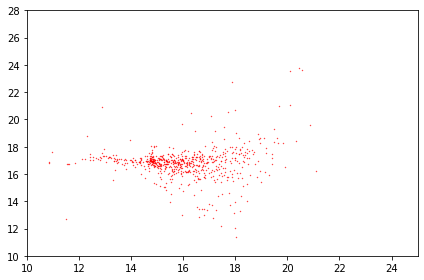

In [253]:
#for r
#Now lets compare the PS r-band magnitudes to our instrumental magnitudes
g=np.where(ps_rmag > 0)  #Only consider objects where I found a match
plt.figure()
plt.scatter(ps_rmag[g],ps_rmag[g]-magr[g],c='red',marker='.',s=0.5)
plt.xlim(10,25)
plt.ylim(10,28)
plt.tight_layout()


/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


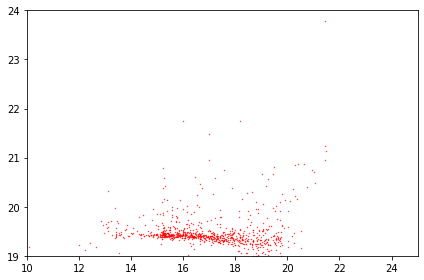

In [254]:
#for g
#Now lets compare the PS g-band magnitudes to our instrumental magnitudes
g=np.where(ps_gmag > 0)  #Only consider objects where I found a match
plt.figure()
plt.scatter(ps_gmag[g],ps_gmag[g]-magg[g],c='red',marker='.',s=0.5)
plt.xlim(10,25)
plt.ylim(19,24)
plt.tight_layout()

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  
/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less_equal
  


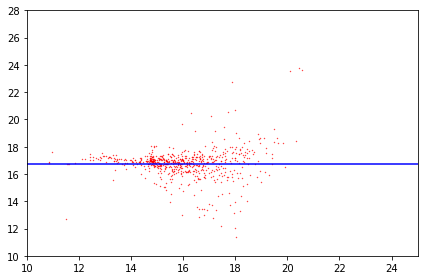

In [255]:
# for r
g2=np.where((ps_rmag > 16) & (ps_rmag < 20) & ((ps_rmag-magr) >= 12) & ((ps_rmag-magr) <= 18))

zpr=np.nanmedian(ps_rmag[g2]-magr[g2])
plt.figure()
plt.scatter(ps_rmag[g],ps_rmag[g]-magr[g],c='red',marker='.',s=0.5)
plt.axhline(y=zpr, color='b', linestyle='-')
plt.xlim(10,25)
plt.ylim(10,28)
plt.tight_layout()

In [256]:
zpr # for r

16.768490902833573

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  
/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less_equal
  


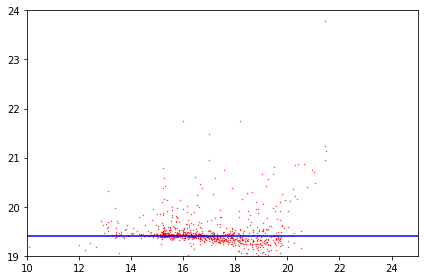

In [259]:
# for g
g2=np.where((ps_gmag > 12) & (ps_gmag < 20) & ((ps_gmag-magg) >= 18) & ((ps_gmag-magg) <= 20))

zpg=np.nanmedian(ps_gmag[g2]-magg[g2])
plt.figure()
plt.scatter(ps_gmag[g],ps_gmag[g]-magg[g],c='red',marker='.',s=0.5)
plt.axhline(y=zpg, color='b', linestyle='-')
plt.xlim(10,25)
plt.ylim(19,24)
plt.tight_layout()

In [260]:
# for g 
zpg

19.404334604689254

In [261]:
#Calculate the flux in cgs units in the r-band (I'll call this fnu)
fnur=np.array(catr['FLUX_AUTO'])*10.**(-0.4*48.6 - 0.4*zpr)
#same but for g-band
fnug=np.array(catg['FLUX_AUTO'])*10.**(-0.4*48.6 - 0.4*zpg)

In [262]:
m_ab_r=(-2.5)*np.log10(fnur)-48.6
m_ab_g=(-2.5)*np.log10(fnug)-48.6

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


/home/daniel/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/daniel/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


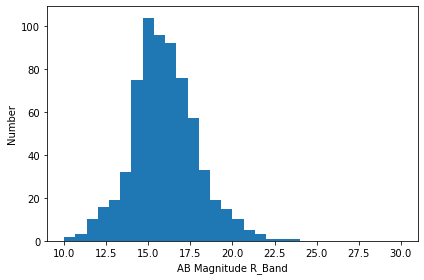

In [263]:
plt.figure()
plt.hist(m_ab_r,bins=30,range=[10,30])
plt.xlabel('AB Magnitude R_Band') ; plt.ylabel('Number')
plt.tight_layout()

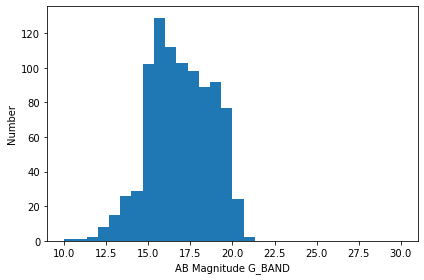

In [264]:
plt.figure()
plt.hist(m_ab_g,bins=30,range=[10,30])
plt.xlabel('AB Magnitude G_BAND') ; plt.ylabel('Number')
plt.tight_layout()

In [ ]:
#take absolute mag and plot against gmag-rmag to get color-magnitude diagram

In [ ]:
# m_ab_* are the true mags
# mag* are the instrumental mags

In [265]:
#g-r color index
color_index=(2.5)*np.log10(fnur/fnug)#flux in r / flux in g

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


In [266]:
#removing objects with panstaars rmags or gmags greater than 18
for i in range(0, len(m_ab_r)):
    if ps_rmag[i]>18 or ps_gmag[i]>19:
        m_ab_r[i]=-99
        m_ab_g[i]=-99

(-22, -5)

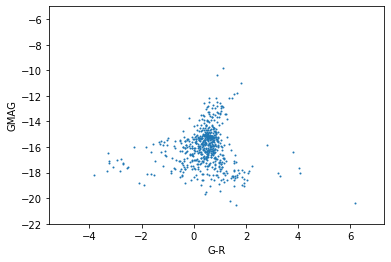

In [267]:
p1=plt.scatter(color_index,-m_ab_g, s=1)
plt.xlabel('G-R')
plt.ylabel('GMAG')
plt.ylim(-22,-5)

(-22, -5)

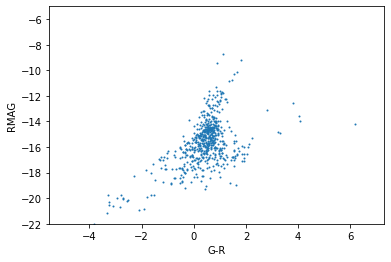

In [268]:
plt.scatter(color_index,-m_ab_r, s=1)
plt.xlabel('G-R')
plt.ylabel('RMAG')
plt.ylim(-22,-5)

(0, 25)

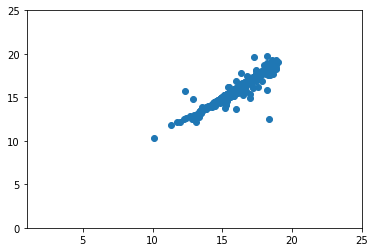

In [269]:
#Panstaars vs corrected magnitude
#G-BAND
plt.close
x,y==range(5,25)
plt.scatter(ps_gmag, m_ab_g)
plt.plot(x,y, Color='red')
plt.xlim(1,25)
plt.ylim(0,25)

(0, 25)

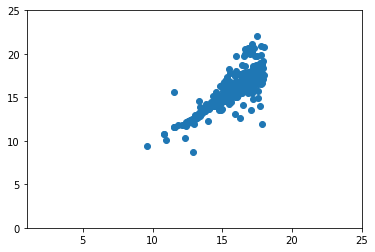

In [270]:
#Panstaars vs corrected magnitude
#R-BAND
x,y==range(5,25)
plt.scatter(ps_rmag, m_ab_r)
plt.plot(x,y, Color='red')
plt.xlim(1,25)
plt.ylim(0,25)

In [271]:
isochrone=ascii.read('output11959225944.dat')
billion=ascii.read('output10billion.dat')
bil=ascii.read('3billion.dat')

In [272]:
len(bil)

368

In [273]:
# column 5 is mass
# column 25 is gmag panstaars
# column 26 is rmag panstaars
# 0-299 logage 9.81291. 6.5e9 years
# 300-599 logage 9.82930 6.75e9 years
# 600-897 logage 9.84510 7e9 years

In [274]:
#for g
def isochronearrayg(int1, int2, isochrone):
    model_g_r=[]
    model_gmag=[]
    for i in range(int1,int2):
        model_g_r.append(isochrone[i][25]-isochrone[i][26])
        model_gmag.append(isochrone[i][25])

    return model_g_r, model_gmag

In [275]:
#for r
def isochronearrayr(int1, int2, isochrone):
    model_g_r=[]
    model_gmag=[]
    for i in range(int1,int2):
        model_g_r.append(isochrone[i][25]-isochrone[i][26])
        model_gmag.append(isochrone[i][26])

    return model_g_r, model_gmag

In [276]:
#adjusting from absolute magnitude to apparent magnitude. NGC188 is at a distance of 1.66kpc
#assuming insignifcant extinction by gas and dust
def magadjuster(absmag):
    returnarry=[]
    for mag in absmag:
        returnarry.append(mag-5+5*np.log10(1.66*10**3))
    return returnarry

In [277]:
g_r1, gmag1 = isochronearrayg(0,299,isochrone)
g_r1, rmag1 = isochronearrayr(0,299,isochrone)

g_r2, gmag2 = isochronearrayg(300,599,isochrone)
g_r2, rmag2 = isochronearrayr(300,599,isochrone)

g_r3, gmag3 = isochronearrayg(600,896,isochrone)
g_r3, rmag3 = isochronearrayr(600,896,isochrone)

g_r, gmag = isochronearrayg(0,275,billion) #10 billion years old
g_r, rmag = isochronearrayr(0,275,billion)

g_r41, gmag4 = isochronearrayr(0,368,bil)#3 billion years old
g_r4, rmag4 = isochronearrayr(0,275,bil)

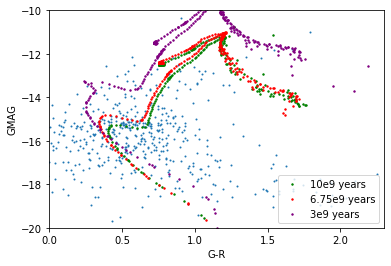

In [281]:
plt.scatter(color_index,-m_ab_g, s=1)
plt.scatter(g_r, magadjuster(gmag)*np.ones(len(gmag))*-1, s=2, color='green', label='10e9 years')
plt.scatter(g_r2, magadjuster(gmag2)*np.ones(len(gmag2))*-1, s=2, color='red', label='6.75e9 years')
plt.scatter(g_r41, magadjuster(gmag4)*np.ones(len(gmag4))*-1, s=2, color='purple', label='3e9 years')
plt.xlabel('G-R')
plt.ylabel('GMAG')
plt.ylim(-20,-10)
plt.xlim(0,2.3)
plt.legend()
#plt.close

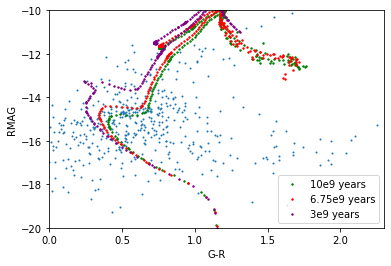

In [282]:
plt.scatter(color_index,-m_ab_r, s=1)
plt.scatter(g_r, magadjuster(rmag)*np.ones(len(rmag))*-1, s=2, color='green', label='10e9 years')
plt.scatter(g_r2, magadjuster(rmag2)*np.ones(len(rmag2))*-1, s=2, color='red', label='6.75e9 years')
plt.scatter(g_r4, magadjuster(rmag4)*np.ones(len(rmag4))*-1, s=2, color='purple', label='3e9 years')
plt.xlabel('G-R')
plt.ylabel('RMAG')
plt.ylim(-20,-10)
plt.xlim(0,2.3)
plt.legend()